# Data Preparation

Data Cleaning and Imputation for columns ignored in the CARES Research Paper.

## Data Pre-Processing

### Observations & Imputation Strategies

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
from duckdb import sql

In [3]:
# Import dataset
data = pd.read_csv("../data/CARES_encoded.csv")

### Drop Duplicated columns

In [4]:
# Remove duplicated records with respect to all columns
data = data.drop_duplicates()
data.reset_index(drop=True, inplace=True)
len(data)

73201

### Check Missing Values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73201 entries, 0 to 73200
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GENDER                             73201 non-null  int64  
 1   RCRI score                         50370 non-null  float64
 2   Anemia category                    72216 non-null  float64
 3   PreopEGFRMDRD                      70069 non-null  float64
 4   DaysbetweenDeathandoperation       5595 non-null   float64
 5   Preoptransfusionwithin30days       73201 non-null  float64
 6   Intraop                            73201 non-null  float64
 7   Postopwithin30days                 73201 non-null  float64
 8   Transfusionintraandpostop          73201 non-null  float64
 9   AnaestypeCategory                  73201 non-null  int64  
 10  PriorityCategory                   73201 non-null  int64  
 11  TransfusionIntraandpostopCategory  73201 non-null  obj

In [6]:
# Define categorical, numeric & target columns
# Define the target columns
target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'Mortality']

# Select categorical columns and exclude target columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
cat_cols = [col for col in cat_cols if col not in target_cols]

# Select numerical columns and exclude target columns
num_cols = data.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col not in target_cols]

# Columns ignored in the research paper
rev_cols = ['RCRI score','PreopEGFRMDRD','Preoptransfusionwithin30days','Intraop','Postopwithin30days','Transfusionintraandpostop','AnaestypeCategory','TransfusionIntraandpostopCategory']

In [7]:
cat_cols

['TransfusionIntraandpostopCategory']

In [8]:
num_cols

['GENDER',
 'RCRI score',
 'Anemia category',
 'PreopEGFRMDRD',
 'DaysbetweenDeathandoperation',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop',
 'AnaestypeCategory',
 'PriorityCategory',
 'AGEcategory',
 'SurgRiskCategory',
 'CVARCRICategory',
 'IHDRCRICategory',
 'CHFRCRICategory',
 'DMinsulinRCRICategory',
 'CreatinineRCRICategory',
 'GradeofKidneyCategory',
 'RDW15.7',
 'ASAcategorybinned',
 'Chinese',
 'Indian',
 'Malay']

In [9]:
target_cols

['ICUAdmgt24h', 'thirtydaymortality', 'Mortality']

In [10]:
rev_cols

['RCRI score',
 'PreopEGFRMDRD',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop',
 'AnaestypeCategory',
 'TransfusionIntraandpostopCategory']

In [11]:
# Function to calculate the percentage of missing data for given columns
def calculate_missing_data_percentage(data, columns):
    missing_data = data[columns].isnull().mean() * 100
    return missing_data

# Calculate the percentage of missing data for reviewed columns
missing_rev_cols = calculate_missing_data_percentage(data, rev_cols)
print("\nPercentage of missing data in review columns:")
print(missing_rev_cols)



Percentage of missing data in review columns:
RCRI score                           31.189465
PreopEGFRMDRD                         4.278630
Preoptransfusionwithin30days          0.000000
Intraop                               0.000000
Postopwithin30days                    0.000000
Transfusionintraandpostop             0.000000
AnaestypeCategory                     0.000000
TransfusionIntraandpostopCategory     0.000000
dtype: float64


In [12]:
mortality_significant_columns = [
    'AGEcategory',
    'SurgRiskCategory',
    'Chinese',
    'Indian',
    'Malay',
    'Anemia category',
    'GradeofKidneyCategory',
    'RDW15.7',
    'CVARCRICategory',
    'IHDRCRICategory',
    'CHFRCRICategory',
    'DMinsulinRCRICategory',
    'ASAcategorybinned',
    'GENDER'
]

## Statistical Tests

### Chi-Squared Test

In [13]:
import scipy.stats as stats

def chi2_test(data, col1, col2):
    contingency_table = pd.crosstab(data[col1].astype(int), data[col2].astype(int))

    # print("Contingency Table:")
    # print(contingency_table)
    
    # Perform the chi-squared test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Output the results
    print(f"Chi-squared Test Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies Table:")
    print(expected)

    # Interpretation
    alpha = 0.05
    if p < alpha:
        print("The result is statistically significant, suggesting an association between the variables.")
    else:
        print("The result is not statistically significant, suggesting no association between the variables.")

### Variance Inflation Factor (Check for Multicollinearity)

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

def vif(columns, df):
    # Assuming X is your independent variables dataframe
    X = df[columns]  # Add more predictors if needed    
    X.dropna(inplace=True)
    X = X.astype(int)
    X = sm.add_constant(X)

    # Calculating VIF for each predictor
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    print(vif_data)

### Logistic Regression and Lowess Curve (Linearity)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def logistic_reg(data, x_col, y_col):
    # Fit the logistic regression model
    df = data.copy()
    X = df[x_col]
    X = sm.add_constant(X)
    y = df[y_col]

    model = sm.Logit(y, X)
    result = model.fit()

    print(result.summary())

    # Calculate the predicted probabilities
    df['predicted_prob'] = result.predict(X)

    # Calculate the logit (log odds)
    df['logit'] = np.log(df['predicted_prob'] / (1 - df['predicted_prob']))

    # Loop through each predictor and plot
    for predictor in x_col:
        sns.regplot(x=df[predictor], y=df[y_col], lowess=True, line_kws={'color': 'red'})
        plt.xlabel(predictor)
        plt.ylabel('Outcome')
        plt.title(f'Lowess Smoothing for {predictor}')
        plt.show()

## Additional Features

In [16]:
df = data.copy()

### 1. **RCRI score**
- ***Definition:*** *Revised Cardiac Risk Index. Six independent predictors of complications were identified and included in a Revised Cardiac Risk Index: high-risk type of surgery, history of ischemic heart disease, history of congestive heart failure, history of cerebrovascular disease, preoperative treatment with insulin, and preoperative serum creatinine >2.0 mg/dL.*
- **Paper**: https://pubmed.ncbi.nlm.nih.gov/10477528/
- Important predictors (based on paper): 'SurgRiskCategory', 'CVARCRICategory', 'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory', 'Age'
- **Suggestion:** 
  - Since RCRI score is dependant on the above important predictors, we do not include it in modelling as it may lead to multi-collinearity.
  - Impute based on ML strategy - Training RF model on important predictors & running inference on RCRI_score.

In [17]:
# Convert float values to strings and remove decimal places
data['RCRI score'] = data['RCRI score'].astype('Int64')
data['RCRI score'] = data['RCRI score'].astype(str)

<Axes: >

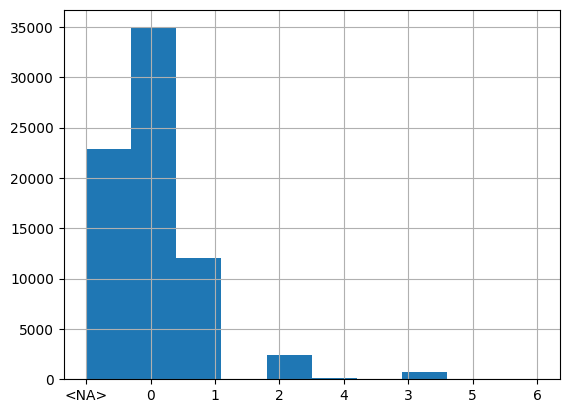

In [18]:
data['RCRI score'].hist(bins=10)

In [19]:
data['RCRI score'].value_counts()

RCRI score
0       34966
<NA>    22831
1       12087
2        2435
3         679
4         168
5          33
6           2
Name: count, dtype: int64

In [20]:
# Replace '<NA>' strings with NaN in the 'RCRI_score' column
data['RCRI score'] = data['RCRI score'].replace('<NA>', np.nan)

In [21]:
subset = data[['RCRI score', 'AGEcategory', 'SurgRiskCategory', 'CHFRCRICategory', 'CVARCRICategory', 'IHDRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory']]
subset1 = subset.loc[(~subset['RCRI score'].isnull())]
subset1.head()

,RCRI score,AGEcategory,SurgRiskCategory,CHFRCRICategory,CVARCRICategory,IHDRCRICategory,DMinsulinRCRICategory,CreatinineRCRICategory
4,0,3,0,0,0,0,0,0
8,0,2,1,0,0,0,0,0
9,1,2,1,0,0,0,0,0
10,0,2,0,0,0,0,0,0
11,1,1,1,0,0,0,0,0


In [22]:
df = data.copy()

In [23]:
data['RCRI score'].isnull().sum()

np.int64(22831)

In [24]:
subset1.columns

Index(['RCRI score', 'AGEcategory', 'SurgRiskCategory', 'CHFRCRICategory',
       'CVARCRICategory', 'IHDRCRICategory', 'DMinsulinRCRICategory',
       'CreatinineRCRICategory'],
      dtype='object')

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def impute_rcri_score(subset, data):
    # Rename the column 'RCRI score' to 'RCRI_score' in both dataframes
    subset.rename(columns={'RCRI score': 'RCRI_score'}, inplace=True)
    data.rename(columns={'RCRI score': 'RCRI_score'}, inplace=True)
    
    # Define the features and target column
    features = ['AGEcategory', 'SurgRiskCategory', 'CHFRCRICategory',
       'CVARCRICategory', 'IHDRCRICategory', 'DMinsulinRCRICategory',
       'CreatinineRCRICategory']
    target_col = 'RCRI_score'
    
    # Separate features and target in subset
    X = subset[features]
    y = subset[target_col]
    
    # Define the Random Forest model with class weights
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the Random Forest model
    rf.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    y_val_pred = rf.predict(X_val)
    print("Validation Set Classification Report:")
    print(classification_report(y_val, y_val_pred))
    
    # Identify rows with missing 'RCRI_score' in the data
    missing_rcri_score = data[target_col].isnull()
    
    # Prepare features for rows with missing 'RCRI_score'
    X_missing = data.loc[missing_rcri_score, features]
    
    # Impute the missing values using the trained Random Forest model
    imputed_rcri_scores = rf.predict(X_missing)
    
    # Impute the missing values in the original data
    data.loc[missing_rcri_score, target_col] = imputed_rcri_scores
    
    return data

In [26]:
data = impute_rcri_score(subset1, data)

C:\Users\danie\AppData\Local\Temp\ipykernel_5320\1876182499.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.rename(columns={'RCRI score': 'RCRI_score'}, inplace=True)


Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      7015
           1       0.44      0.60      0.51      2352
           2       0.48      0.77      0.59       517
           3       0.55      0.66      0.60       146
           4       0.52      0.62      0.57        37
           5       0.38      0.43      0.40         7

    accuracy                           0.71     10074
   macro avg       0.55      0.64      0.58     10074
weighted avg       0.77      0.71      0.73     10074



In [27]:
df['RCRI score'].isnull().sum()

np.int64(22831)

In [28]:
df['RCRI score'].value_counts()

RCRI score
0    34966
1    12087
2     2435
3      679
4      168
5       33
6        2
Name: count, dtype: int64

In [29]:
data['RCRI_score'].isnull().sum()

np.int64(0)

In [30]:
data['RCRI_score'].value_counts()

RCRI_score
0    51038
1    18528
2     2735
3      695
4      170
5       33
6        2
Name: count, dtype: int64

In [31]:
data.Mortality.value_counts()

Mortality
0    67606
1     5595
Name: count, dtype: int64

In [32]:
vif(['RCRI_score', 'AGEcategory', 'SurgRiskCategory', 'CHFRCRICategory', 'CVARCRICategory', 'IHDRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory'], data)

C:\Users\danie\AppData\Local\Temp\ipykernel_5320\910535912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


                  feature       VIF
0                   const  4.141653
1              RCRI_score  3.093313
2             AGEcategory  1.092300
3        SurgRiskCategory  1.367298
4         CHFRCRICategory  1.168712
5         CVARCRICategory  1.193143
6         IHDRCRICategory  1.573336
7   DMinsulinRCRICategory  1.251428
8  CreatinineRCRICategory  1.356384


In [33]:
data['RCRI_score'].value_counts()

RCRI_score
0    51038
1    18528
2     2735
3      695
4      170
5       33
6        2
Name: count, dtype: int64

In [34]:
chi2_test(data, 'RCRI_score', 'Mortality')

Chi-squared Test Statistic: 2775.0014149378367
P-value: 0.0
Degrees of Freedom: 6
Expected Frequencies Table:
[[4.71369930e+04 3.90100695e+03]
 [1.71118423e+04 1.41615770e+03]
 [2.52595470e+03 2.09045300e+02]
 [6.41878799e+02 5.31212005e+01]
 [1.57006325e+02 1.29936749e+01]
 [3.04776984e+01 2.52230161e+00]
 [1.84713324e+00 1.52866764e-01]]
The result is statistically significant, suggesting an association between the variables.


In [35]:
data.drop(columns=['RCRI_score'], axis=1, inplace=True)

### 2. **Preoperative Estimated Glomerular Filtration Rate using the Modification of Diet in Renal Disease (PreopEGFRMDRD)**
- **Definition:** Estimated glomerular filtration rate (eGFR), describing filtrate flow through the kidneys, is a universal surrogate indicator for assessing renal function. It has been widely used in the clinical diagnosis of chronic kidney disease (CKD).
- The PreopEGFRMDRD is typically measured in mL/min/1.73m² and is used to assess kidney function. Normal values generally range from 90 to 120 mL/min/1.73m², with lower values indicating impaired kidney function.
- Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7936476/
- **Insights:** In this study, they confirmed an independent nonlinear relationship between preop-eGFR and postoperative 30-day mortality. A stable U-shaped trend can be seen in this relationship. When preop-eGFR ≤ 98.688 mL/min/1.73 m2, the 30-day mortality would be decreased by 1.6% for each additional unit of preop-eGFR. While preop-eGFR > 98.688 mL/min/1.73 m2, there would be a 1.3% increase of 30-day mortality rate for each additional unit of preop-eGFR. CHF, DM, IHD and anemia complications (CHF, DM, IHD acting as a promoting factor, while anemia as an inhibitory factor) interfere with the effect of preop-eGFR on postoperative 30-day mortality.
- The paper excluded all cases of missing data for preop-eGFR and outliers.
- **Suggestion:** Based on the findings in the paper, we will classify the feature into two classes: preop-eGFR ≤ 98.688 mL/min/1.73 m2 (0) and preop-eGFR > 98.688 mL/min/1.73 m2 (1)

In [36]:
data.columns

Index(['GENDER', 'Anemia category', 'PreopEGFRMDRD',
       'DaysbetweenDeathandoperation', 'Preoptransfusionwithin30days',
       'Intraop', 'Postopwithin30days', 'Transfusionintraandpostop',
       'AnaestypeCategory', 'PriorityCategory',
       'TransfusionIntraandpostopCategory', 'AGEcategory', 'Mortality',
       'thirtydaymortality', 'SurgRiskCategory', 'CVARCRICategory',
       'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory',
       'CreatinineRCRICategory', 'GradeofKidneyCategory', 'RDW15.7',
       'ASAcategorybinned', 'ICUAdmgt24h', 'Chinese', 'Indian', 'Malay'],
      dtype='object')

In [37]:
data=data.dropna(subset=['PreopEGFRMDRD'])

In [38]:
threshold = 98.688

# Create a new binary feature based on the threshold
data['eGFR_Class'] = data['PreopEGFRMDRD'].apply(lambda x: 1 if x > threshold else 0)

# Print the first few rows to verify the new feature
print(data[['PreopEGFRMDRD', 'eGFR_Class']].head())

   PreopEGFRMDRD  eGFR_Class
2     152.538570           1
3     117.231496           1
4      98.651255           0
5     104.487306           1
6      72.669742           0


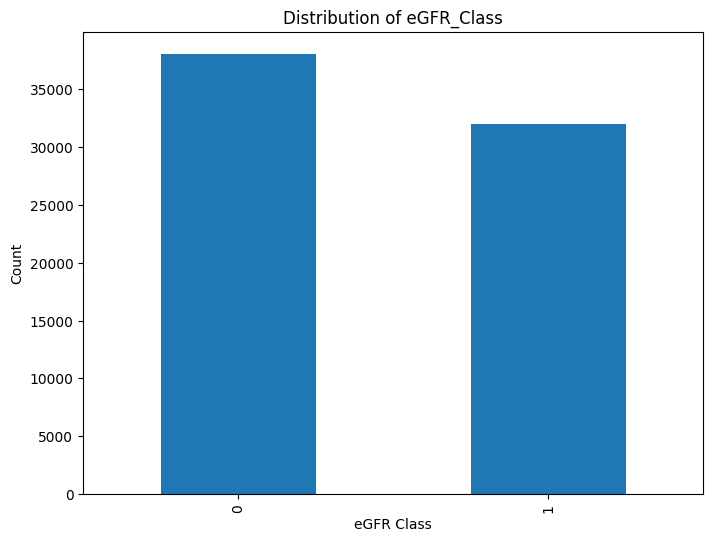

In [39]:
# Visualize the distribution of the new binary feature
plt.figure(figsize=(8, 6))
data['eGFR_Class'].value_counts().plot(kind='bar')
plt.title('Distribution of eGFR_Class')
plt.xlabel('eGFR Class')
plt.ylabel('Count')
plt.show()

In [40]:
data['PreopEGFRMDRD'] = data['eGFR_Class']
data.drop(columns=['eGFR_Class'], inplace=True)

In [41]:
vif(mortality_significant_columns+['PreopEGFRMDRD'], df)

C:\Users\danie\AppData\Local\Temp\ipykernel_5320\910535912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


                  feature        VIF
0                   const  49.681184
1             AGEcategory   1.449098
2        SurgRiskCategory   1.066804
3                 Chinese   2.499203
4                  Indian   1.781012
5                   Malay   1.875836
6         Anemia category   1.435052
7   GradeofKidneyCategory   3.360468
8                 RDW15.7   1.255222
9         CVARCRICategory   1.047385
10        IHDRCRICategory   1.187558
11        CHFRCRICategory   1.083906
12  DMinsulinRCRICategory   1.071112
13      ASAcategorybinned   1.472165
14                 GENDER   1.071524
15          PreopEGFRMDRD   3.150406


In [42]:
chi2_test(data, 'PreopEGFRMDRD', 'Mortality')

Chi-squared Test Statistic: 495.85786068039965
P-value: 7.572227216475161e-110
Degrees of Freedom: 1
Expected Frequencies Table:
[[35162.73627424  2920.26372576]
 [29533.26372576  2452.73627424]]
The result is statistically significant, suggesting an association between the variables.


In [43]:
mortality_significant_columns.append('PreopEGFRMDRD')

### **3. Perioperative transfusion (Preoptransfusionwithin30days, Intraop, Postopwithin30days)**
- **Definition:** Perioperative blood transfusions are often associated with an increased risk of postoperative complications, including infection, cardiovascular events, and increased mortality. This is particularly significant in patients undergoing major surgeries.
- **Paper:** https://pubmed.ncbi.nlm.nih.gov/15784356/
- **Insights:** The study found that patients who received peri-operative RBC transfusions had higher 30-day and 1-year mortality rates compared to those who did not receive transfusions.
- Kaplan-Meier survival curves showed a clear survival disadvantage for patients receiving RBC transfusions. This effect was observed both at 30 days and at 1 year post-surgery.
- **Paper:** https://pubs.asahq.org/anesthesiology/article/114/2/283/10961/Association-between-Intraoperative-Blood
- **Insights:** This multicenter observational study suggests that intraoperative blood transfusion is associated with a higher risk of mortality and morbidity. It is unknown whether this association is due to the adverse effects of blood transfusion or is, instead, the result of increased blood loss in the patients receiving blood. The study emphasizes the importance of considering intraoperative transfusions as a significant risk factor in predicting short-term outcomes after surgery.
- **Paper:** https://jamanetwork.com/journals/jama/article-abstract/187160
- **Insights:** Perioperative transfusion in patients with hemoglobin levels 80 g/L (8.0 g/dL) or higher did not appear to influence the risk of 30- or 90-day mortality in this elderly population. At hemoglobin concentrations of less than 80 g/L (8.0 g/dL), 90.5% of patients received a transfusion, precluding further analysis of the association of transfusion and mortality.
- **Suggestions:** 
  - Classify the field as 1 and 0 if the patient recieved Pre-op and Post-Op transfusion.
  - We could also group all three transfusion columns and name the feature as Perioperativetransfusion (1, 0), presence of a single transfusion using OR operation.
  - Need to make a decision of whether the field should be used as research papers support both arguments, will need to check from a statistical view-point.

In [44]:
data['Preoptransfusionwithin30days'].value_counts()

Preoptransfusionwithin30days
0.0     68276
1.0       961
2.0       437
3.0       178
4.0        73
5.0        45
6.0        23
7.0        23
8.0        19
11.0        8
10.0        7
9.0         6
13.0        5
14.0        4
17.0        1
12.0        1
20.0        1
21.0        1
Name: count, dtype: int64

In [45]:
data['Intraop'].value_counts()

Intraop
0.0    65348
1.0     4721
Name: count, dtype: int64

In [46]:
data['Postopwithin30days'].value_counts()

Postopwithin30days
0.0     69140
1.0       595
2.0       179
3.0        61
4.0        34
5.0        23
6.0        12
7.0         9
8.0         5
12.0        3
9.0         3
15.0        2
23.0        1
16.0        1
10.0        1
Name: count, dtype: int64

In [47]:
transfusion_cols = ['Preoptransfusionwithin30days', 'Intraop', 'Postopwithin30days']

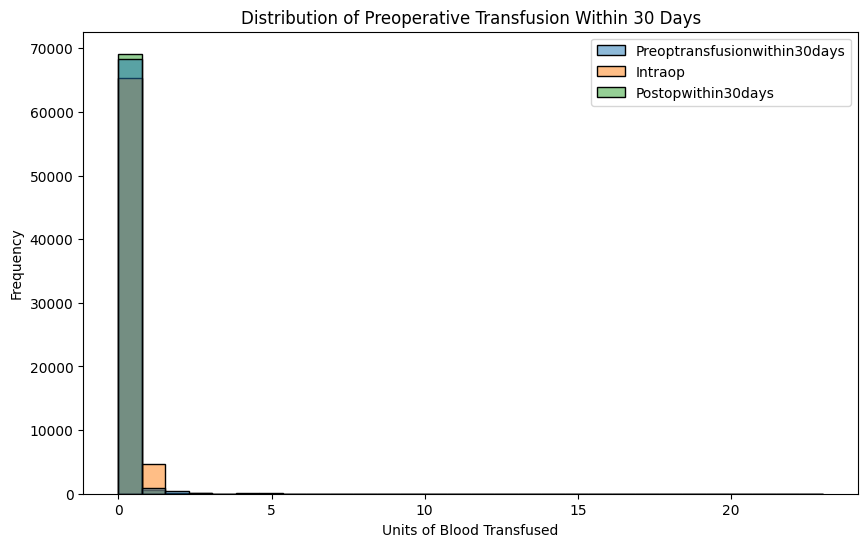

In [48]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data[transfusion_cols], bins=30, color='blue')
plt.title('Distribution of Preoperative Transfusion Within 30 Days')
plt.xlabel('Units of Blood Transfused')
plt.ylabel('Frequency')
plt.show()

Multicollinearity: Check Variance Inflation Factor (VIF) values. If VIF values are significantly higher than 10, it may indicate problematic multicollinearity.

In [49]:
vif(mortality_significant_columns + transfusion_cols, data)

C:\Users\danie\AppData\Local\Temp\ipykernel_5320\910535912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


                         feature        VIF
0                          const  18.648417
1                    AGEcategory   1.472328
2               SurgRiskCategory   1.113226
3                        Chinese   2.500236
4                         Indian   1.782070
5                          Malay   1.876494
6                Anemia category   1.532576
7          GradeofKidneyCategory   2.138049
8                        RDW15.7   1.262833
9                CVARCRICategory   1.047419
10               IHDRCRICategory   1.187505
11               CHFRCRICategory   1.084946
12         DMinsulinRCRICategory   1.072987
13             ASAcategorybinned   1.484155
14                        GENDER   1.075018
15                 PreopEGFRMDRD   1.899802
16  Preoptransfusionwithin30days   1.298857
17                       Intraop   1.421473
18            Postopwithin30days   1.180681


Check linearity of the relationship between 'Preoptransfusionwithin30days' and 'Mortality'.

Optimization terminated successfully.
         Current function value: 0.258319
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Mortality   No. Observations:                73201
Model:                          Logit   Df Residuals:                    73197
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                 0.04316
Time:                        01:09:29   Log-Likelihood:                -18909.
converged:                       True   LL-Null:                       -19762.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -2.6837      0.016   -171.445      0.000

d:\OneDrive - Singapore Management University\SMU Singapore\Academics\Jul 2024\Applied Healthcare Analytics\CARES_Analytics\venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


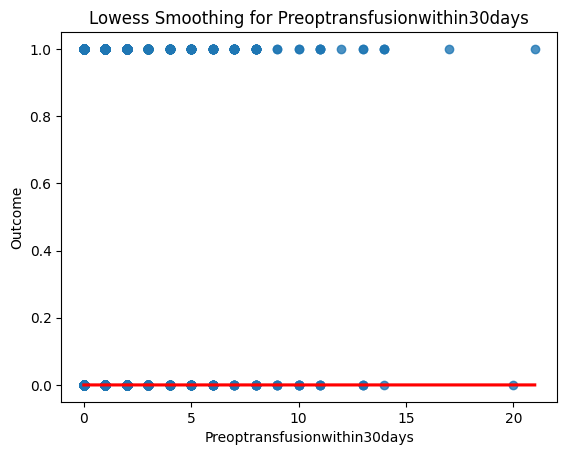

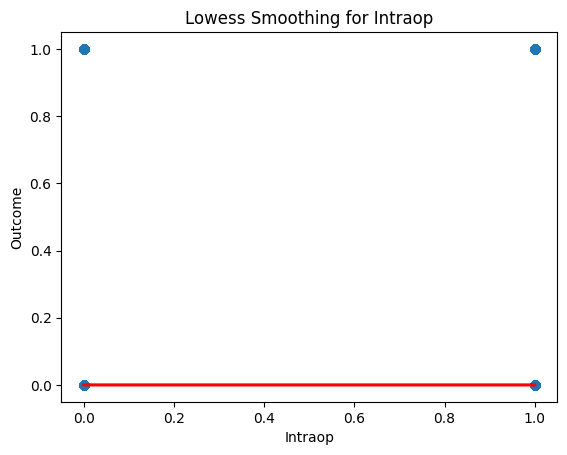

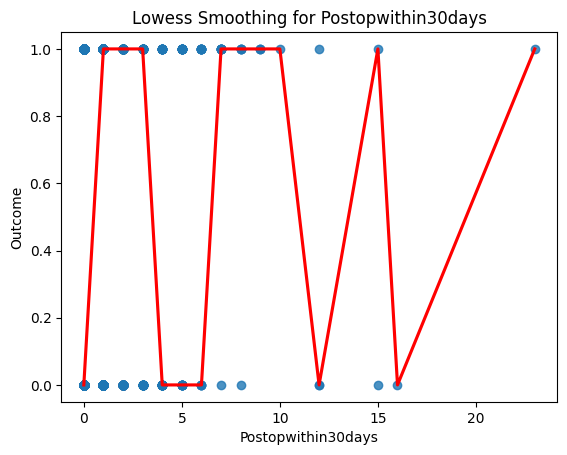

In [50]:
logistic_reg(df, x_col=transfusion_cols, y_col='Mortality')

In [51]:
data['Preoptransfusionwithin30days'] = data['Preoptransfusionwithin30days'].apply(lambda x: 1 if x > 0 else 0)
data['Postopwithin30days'] = data['Postopwithin30days'].apply(lambda x: 1 if x > 0 else 0)

In [52]:
chi2_test(data, 'Preoptransfusionwithin30days', 'Mortality')

Chi-squared Test Statistic: 1725.5908178125842
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies Table:
[[63040.49003125  5235.50996875]
 [ 1655.50996875   137.49003125]]
The result is statistically significant, suggesting an association between the variables.


In [53]:
chi2_test(data, 'Intraop', 'Mortality')

Chi-squared Test Statistic: 2212.4945307255275
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies Table:
[[60337.01362942  5010.98637058]
 [ 4358.98637058   362.01362942]]
The result is statistically significant, suggesting an association between the variables.


In [54]:
chi2_test(data, 'Postopwithin30days', 'Mortality')

Chi-squared Test Statistic: 1142.1288959239616
P-value: 2.3044353017239638e-250
Degrees of Freedom: 1
Expected Frequencies Table:
[[63838.23716622  5301.76283378]
 [  857.76283378    71.23716622]]
The result is statistically significant, suggesting an association between the variables.


Optimization terminated successfully.
         Current function value: 0.258531
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Mortality   No. Observations:                70069
Model:                          Logit   Df Residuals:                    70065
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                 0.04456
Time:                        01:09:30   Log-Likelihood:                -18115.
converged:                       True   LL-Null:                       -18960.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -2.6839      0.016   -167.874      0.000

d:\OneDrive - Singapore Management University\SMU Singapore\Academics\Jul 2024\Applied Healthcare Analytics\CARES_Analytics\venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


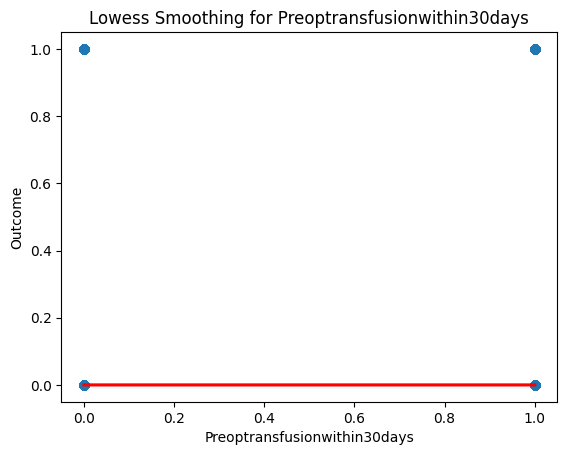

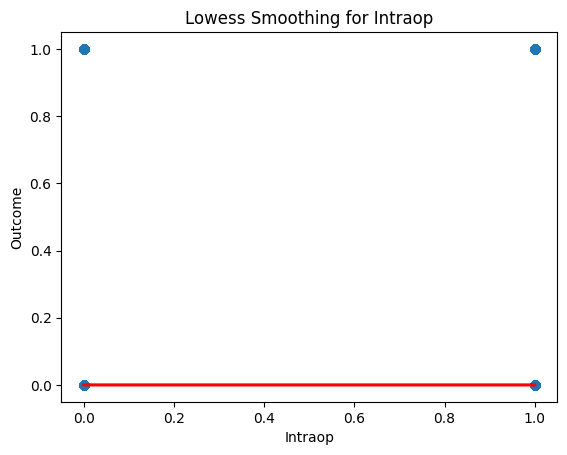

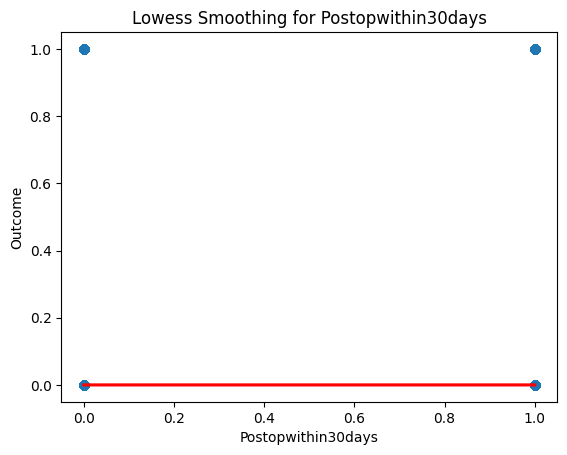

In [55]:
logistic_reg(data, x_col=transfusion_cols, y_col='Mortality')

We see statistical significance with all transfusion columns and no multi-collinearity.

Given that there is statistical significance and there is no problem of multi-collinearity we can use this feature for modelling

In [56]:
data['Perioperativetransfusionwithin30days'] = data[transfusion_cols].any(axis=1).astype(int)

In [57]:
chi2_test(data, 'Perioperativetransfusionwithin30days', 'Mortality')

Chi-squared Test Statistic: 2247.8138034451267
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies Table:
[[60305.62080235  5008.37919765]
 [ 4390.37919765   364.62080235]]
The result is statistically significant, suggesting an association between the variables.


In [58]:
vif(mortality_significant_columns + ['Perioperativetransfusionwithin30days'], data)

C:\Users\danie\AppData\Local\Temp\ipykernel_5320\910535912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


                                 feature        VIF
0                                  const  18.634788
1                            AGEcategory   1.471342
2                       SurgRiskCategory   1.112888
3                                Chinese   2.499782
4                                 Indian   1.781901
5                                  Malay   1.876286
6                        Anemia category   1.531496
7                  GradeofKidneyCategory   2.136394
8                                RDW15.7   1.257398
9                        CVARCRICategory   1.047421
10                       IHDRCRICategory   1.187419
11                       CHFRCRICategory   1.084564
12                 DMinsulinRCRICategory   1.072953
13                     ASAcategorybinned   1.478963
14                                GENDER   1.074104
15                         PreopEGFRMDRD   1.899500
16  Perioperativetransfusionwithin30days   1.177623


Optimization terminated successfully.
         Current function value: 0.259645
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Mortality   No. Observations:                70069
Model:                          Logit   Df Residuals:                    70067
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                 0.04044
Time:                        01:09:32   Log-Likelihood:                -18193.
converged:                       True   LL-Null:                       -18960.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.6858      0.0

d:\OneDrive - Singapore Management University\SMU Singapore\Academics\Jul 2024\Applied Healthcare Analytics\CARES_Analytics\venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


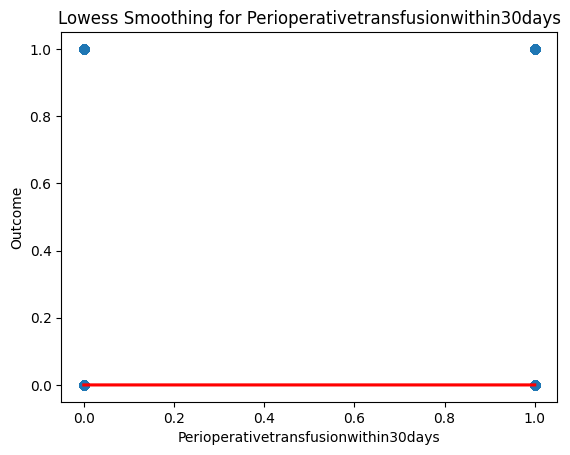

In [59]:
logistic_reg(data, x_col=['Perioperativetransfusionwithin30days'], y_col='Mortality')

In [60]:
data.drop(columns=transfusion_cols, inplace=True)

### 4. **Intra and Post op transfusion - categorical (TransfusionIntraandpostopCategory)**
- **Definition:** Categorical column created from Transfusionintraandpostop.
- **Suggestion:** Drop the column as it is redundant

In [61]:
data.TransfusionIntraandpostopCategory.value_counts()

TransfusionIntraandpostopCategory
0 units            65336
1 unit              3813
2 or more units      920
Name: count, dtype: int64

In [62]:
data.drop(columns=['TransfusionIntraandpostopCategory'], inplace=True)

### 5. **Type of anaesthesia (AnaestypeCategory)**
- **Definition:** Anesthesia has the potential to induce physiological changes that may lead to morbidity and mortality. As a result, it is commonly regarded as a high-risk activity. A number of investigators, however, have reported that anesthesia-related mortality rates have declined over the past two decades. This decrease has been attributed to a variety of safety improvements including improved monitoring techniques, the development and widespread adoption of practice guidelines, and other systematic approaches to error reduction.
- **Paper:** https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2763076/
- **Insights:** In conclusion, our systematic review of the literature confirms that perioperative mortality rates are higher in Brazil and other developing countries than in developed countries. Anesthesia-related mortality rates in Brazil and in developed countries are similar and lower than 1 per 10,000 anesthetics. Major risk factors for mortality are apparent for newborns, children under 1 year of age, the elderly, males, patients of ASA III or poorer physical status, emergency surgeries, during general anesthesia, and in cardiac, vascular, thoracic, gastroenterologic, orthopedic, and pediatric surgeries. Medication-related cardiocirculatory events and airway management accounted for the majority of the cases of anesthesia-related mortality. These data may be useful in developing prevention strategies.
- **Suggestion:** Check for statistical significance as the feature seems to be related to mortality but very rarely in developed countries and this rate is decreasing with each year.

In [63]:
data.AnaestypeCategory.value_counts()

AnaestypeCategory
0    58740
1    11329
Name: count, dtype: int64

In [64]:
chi2_test(data, 'AnaestypeCategory', 'Mortality')

Chi-squared Test Statistic: 169.67273382670433
P-value: 8.722582339921896e-39
Degrees of Freedom: 1
Expected Frequencies Table:
[[54235.72535643  4504.27464357]
 [10460.27464357   868.72535643]]
The result is statistically significant, suggesting an association between the variables.


In [65]:
vif(mortality_significant_columns + ['AnaestypeCategory'], data)

C:\Users\danie\AppData\Local\Temp\ipykernel_5320\910535912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


                  feature        VIF
0                   const  18.641504
1             AGEcategory   1.538803
2        SurgRiskCategory   1.066286
3                 Chinese   2.501917
4                  Indian   1.782459
5                   Malay   1.878869
6         Anemia category   1.445427
7   GradeofKidneyCategory   2.142325
8                 RDW15.7   1.256455
9         CVARCRICategory   1.047400
10        IHDRCRICategory   1.187412
11        CHFRCRICategory   1.085119
12  DMinsulinRCRICategory   1.074361
13      ASAcategorybinned   1.477333
14                 GENDER   1.074114
15          PreopEGFRMDRD   1.900712
16      AnaestypeCategory   1.102976


### 6. **Intra and Post op transfusion (Transfusionintraandpostop)**
- **Definition:** Column created from Intra and Post op transfusion.
- **Suggestion:** Drop the column as it is redundant

In [66]:
data.Transfusionintraandpostop.value_counts()

Transfusionintraandpostop
0.0     65336
1.0      3813
2.0       589
3.0       176
4.0        61
5.0        34
6.0        23
7.0        12
8.0         9
9.0         5
13.0        3
10.0        3
16.0        2
24.0        1
17.0        1
11.0        1
Name: count, dtype: int64

In [67]:
data.drop(columns=['Transfusionintraandpostop'], inplace=True)

In [68]:
data.columns

Index(['GENDER', 'Anemia category', 'PreopEGFRMDRD',
       'DaysbetweenDeathandoperation', 'AnaestypeCategory', 'PriorityCategory',
       'AGEcategory', 'Mortality', 'thirtydaymortality', 'SurgRiskCategory',
       'CVARCRICategory', 'IHDRCRICategory', 'CHFRCRICategory',
       'DMinsulinRCRICategory', 'CreatinineRCRICategory',
       'GradeofKidneyCategory', 'RDW15.7', 'ASAcategorybinned', 'ICUAdmgt24h',
       'Chinese', 'Indian', 'Malay', 'Perioperativetransfusionwithin30days'],
      dtype='object')

In [69]:
data.to_csv('../data/CARES_encoded_ignorecols.csv', index=False)